# Segmentez des clients d'un site e-commerce
## Notebook 3 : Tests de modèles de clustering
OpenClassrooms - Parcours Data Scientist - Projet 05  

## Présentation du projet

**Contexte**  


* Olist est une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne.  
* Dans un premier temps il est demandé de réaliser quelques requêtes pour le dashboard à partir de la base de données SQLite d'Olist.  
* La mission principale est de fournir aux équipes d'e-commerce d'Olist une **segmentation des clients** qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.
* Cette mission se concluera par la simulation d'un contrat de maintenance.

**Démarche globale**  
* Requêtes SQL pour le dashboard (cf Notebook 1)  
* Feature ingineering (cf Notebook 2)
* **Tests de modèles de clustering** : c'est l'objet de ce notebook  
* Simulation d'un contrat de maintenace (Notebook 4)  

**Tests de modèles de clustering**  
* Objectif métier :  
   * Obtenir entre **5 et 8 profils** de clients, clairement identifiés pour que l'équipe Marketing d'Olist puisse planifier des campagnes adaptées  
   * Exemple : *Les clients ayant passé 1 seule commande, il y a moins de 6 mois, d'un montant supérieur à 500 réals*
* Contrainte :
   * Seulement 3 %  des clients d'Olist ont passé plus d'une commande
   * Il est impératif d'un point de vue métier que ces clients soient clairement identifiés 
* Critères :
   * Analyse de la taille des clusters
   * Analyse des distances inter-clusters  
   * Analyse des éventuels chevauchements
   * Analyse de l'interprétabilité métier, critère décisif quant au choix de la segmentation retenue

## Sommaire  
**Préparation de l'environnement**  
* Environnement virtuel
* Import des modules
* Fonctions
* Chargement du dataset  

**Les features RFM**  
* Récence
* Fréquence
* Montant
* Jeu de combinaisons de features à tester

**Modèle de clustering KMeans**  
* Présentation de l'algorithme  
* Paramétrage du modèle
* Recherche du nombre optimal de clusters / version de la feature `Montant`  
* Interprétation métier du clustering KMeans en 6 clusters

**Modèle de clustering DBSCAN**  
* Présentation de l'algorithme
* Échantillonage des données
* Recherche des hyperparamètres optimaux
* Vérification de l'interprétabilité  

**Modèle de clustering AgglomerativeClustering**  
* Présentation de l'algorithme
* Choix des hyperparamètres  
* Échantillonage des données
* Affichage des dendrogrammes  
* Segmentation en 3 clusters
* Conclusion du test AgglomerativeClustering

**Annexe : visualisation du clustering KMeans après PCA**  

# 1 Préparation de l'environnement

## 1.1 Environnement virtuel

In [1]:
# Vérification environnement virtuel
envs = !conda env list
print(f"Environnement virtuel : {[e for e in envs if '*' in e][0].split('*')[1].strip()}")

Environnement virtuel : C:\Users\chrab\anaconda3\envs\opc5


## 1.2 Import des modules

* Installation conditionnelle des librairies

In [2]:
import sys
import subprocess
import pkg_resources

def install_package(package):
    """Installe une librairie en mode silencieux si elle n'est pas encore installée"""
    try:
        pkg_resources.get_distribution(package)
    except pkg_resources.DistributionNotFound:
        print(f"Installation {package}... ", end='')
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])
        print(f"Terminé.")
    else:
        print(f"{package} est déjà installé.")

In [3]:
# Installation des librairies
install_package('pandas')
install_package('numpy')
install_package('matplotlib')
install_package('seaborn')
install_package('scikit-learn')
install_package('yellowbrick')
install_package('scipy')

pandas est déjà installé.
numpy est déjà installé.
matplotlib est déjà installé.
seaborn est déjà installé.
scikit-learn est déjà installé.
yellowbrick est déjà installé.
scipy est déjà installé.


* Import des modules

In [4]:
# Import des modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
import scipy.cluster.hierarchy as sch
import pickle

* Paramétrages

Un certain nombre de cellules de ce notebook sont longues à calculer (scores de silhouette, fit du modèle AgglomerativeClustering...)  
Pour toutes les opérations coûteuses en temps un fichier contenent leur résultat a été enregistré (csv, pickle ou png)  
En mode **FAST_MODE**, les fichiers sont chargés en priorité s'ils existent (sinon ils sont créés)

In [5]:
# FAST_MODE = False : Force l'exécution du code concerné, et écrase les fichiers s'ils existent
FAST_MODE = True

## 1.3 Fonctions

In [6]:
# Affichage graphiques Elbow Method et Calinski-Harabasz pour visualiser le nombre optimal de clusters KMeans
def plot_kmeans_elbow_visualizers(X, k=(3, 11)):
    """
    Affiche les graphiques Yellowbricks Elbow Method et Calinski-Harabasz pour KMeans

    Parameters:
        X (array-like) : Données à clusteriser
        k (tuple)      : Plage des nombres de clusters à tester
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Initialisation du modèle
    model = KMeans(random_state=0, init='k-means++')   
    metrics = ['distortion', 'calinski_harabasz']
    
    for ax, metric in zip(axes, metrics):
        visualizer = KElbowVisualizer(model, k=(3, 11), metric=metric, ax=ax)
        visualizer.fit(X)
        visualizer.finalize()
    plt.suptitle(X.columns[-1])
    plt.tight_layout()
    plt.show()

In [7]:
def plot_silhouettevisualizer(X, k):
    """
    Affiche et sauvegarde le graphique SilhouetteVisualizer d'un modèle KMeans
    
    Parameters :
        X (array-like) : données
        k (int)       : nombre de clusters
    """
    # Initialisation du modèle KMeans
    model = KMeans(n_clusters=k, random_state=0, init='k-means++')
    # Initialisation et fit du visualiseur
    visualizer = SilhouetteVisualizer(model)
    visualizer.fit(X)
    # Enregistrement et affichage du graphique
    filename = f"silhouette_plot_kmeans_{k}_clusters_{X.columns[-1]}.png"
    visualizer.show(outpath=filenname)

In [8]:
def plot_intercluster_distance_map_kmeans(X, n_clusters):
    """
    Affiche et sauvegarde le graphique Intercluster Distance Map d'un modèle KMeans
    
    Parameters :
        X (array-like) : données
        k (int)        : nombre de clusters    
    """
    # Nom du fichier png à sauvegarder
    filename = f'intercluster_distance_map_kmeans_{n_clusters}_clusters_{X.columns[-1]}.png'
    # Initialisation du modèle KMeans
    model = KMeans(n_clusters=6, random_state=0, init='k-means++')
    # Initialisation et fit du visualiseur
    visualizer = InterclusterDistance(model)   
    visualizer.fit(X)
    # Enregistrement et affichage du graphique
    visualizer.show(outpath=filename)
    plt.show()

In [9]:
def pca_explained_variance(X, n_components):
    """
    Renvoit le pourcentage de variance expliquée des 'n_components' premières composantes
    principales d'une PCA.

    Parameters:
        X (array-like)     : Données sur lesquelles portent l'analyse en composantes principales
        n_components (int) : Nombre de composantes principales désiré

    Returns:
        explained_variance (float) : Pourcentage de variance expliquée
    """
    # Centrer-réduire les variables (obligatoire pour une PCA)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Réalisation de la PCA
    pca = PCA(n_components=n_components)
    principalComponents = pca.fit_transform(X_scaled)
    
    # Calcul du pourcentage de variance expliquée total
    variance_explained = sum(pca.explained_variance_ratio_)

    return variance_explained

In [10]:
def search_dbscan_parameters(dataframe, features, min_samples_range, epsilon_range):
    """
    Calcule le nombre de clusters et le nombre de points de bruits pour toutes les combinaisons
    de features, pour les plages de min_samples et epsilon fournies d'un modèle DBSCAN.

    Parameters:
        dataframe (pandas.DataFrame) : DataFrame dans lequel se trouve les données
        features (list)              : Liste de listes des combinations de features à utiliser
        min_sample_rang (range)      : Plage de valeurs 'min_samples'
        epsilon_range (range)        : Plage de valeurs 'epsilon'
        
    Returns:
        df_dbscan_epsilon_tests (pandas.DataFrame) : DataFrame contenant les résultats
    """
    # Stockage des résultats
    epsilon_results = []

    X = dataframe[features]
    feature_montant = X.columns[-1]
    print(f"Calculs '{feature_montant}' : .", end='')

    # Boucle sur les valeurs d'epsilon
    for eps in epsilon_range:
        # Boucle sur les valeurs de min_samples
        for min_samples_value in min_samples_range:
            # Application du modèle DBSCAN sur l'échantillon
            dbscan = DBSCAN(eps=eps, min_samples=min_samples_value).fit(X)
            # Récupération des labels de clusters
            labels = dbscan.labels_
            
            # Calcul du score de silhouette, sauf si tous les points sont considérés comme du bruit
            # if len(set(labels)) > 1:
            #     silhouette_avg = silhouette_score(X, labels)
            # else:
            #     silhouette_avg = -1
            
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise_ = list(labels).count(-1)
        
            # Stockage des résultats
            epsilon_results.append((feature_montant, eps, min_samples_value, n_clusters_, n_noise_))#, silhouette_avg))
            print('.', end='')
    print()

    # Conversion des résultats en DataFrame
    df_dbscan_parameters_tests = pd.DataFrame(epsilon_results, columns=[
        'feature_montant',
        'eps',
        'min_samples_value',
        'n_clusters',
        'n_noise',
        # 'silhouette_score'
    ])

    return df_dbscan_parameters_tests

In [11]:
def plot_elbow_nearest_neighbors(X, k, ax=None):
    """
    Affiche la courbe distances / indices qui permet de visualiser la valeur d'epsilon du modèle DBSCAN
    en fonction du nombre d'observations.
    
    Parameters:
        X (array-like)            : Données à clusteriser
        k (int)                   : Nombre de points voisins à prendre en considération pour le calcul de la distance
        ax (matplotlib.axes.Axes) : Axe sur lequel tracer le graphique
    Returns:
        max_distance  : Distance maximum entre un point et ses k plus proches voisins (= epsilon max)
    """
    if ax is None:
        ax = plt.gca()

    # Instanciation
    nearest_neighbors = NearestNeighbors(n_neighbors=k)
    # Alimentation du modèle
    neighbors = nearest_neighbors.fit(X)
    # Récupération des distances et indices des points observés
    distances, indices = neighbors.kneighbors(X)
    # Tri par distance pour le graphique
    distances = np.sort(distances, axis=0)
    distances = np.round(distances[:,1], 4)  # Prendre la distance au k-ème plus proche voisin
    # Distance maximale
    max_distance = max(distances)
    
    # Affichage de la courbe distances / indices
    ax.plot(distances)
    ax.set_title(f"{X.columns[-1]}", pad=10)
    ax.set_xlabel("Échantillon (10 % des observations)")
    ax.set_ylabel("Distance au k-ème plus proche voisin")
    ax.text(0, max(distances), f"Distance maximale : {max_distance}", verticalalignment='top', horizontalalignment='left')

    return max_distance

In [12]:
def plot_dendrogram(ax, agglomerative_model, linkage, metric, n_clusters):
    """
    Génère un dendrogramme

    Parameters:
        ax (matplotlib.axes.Axes)          : Axe sur lequel tracer le dendrogramme
        agglomerative_model (fitted model) : Modèle fitté de type AgglomerativeClustering
        linkage (str)                      : Méthode de linkage ('single', 'complete', 'average' ou 'ward')
        metric (str)                       : Méthode de calcul de la distance ('euclidean', 'Manhattan'...)
        n_clusters (int)                   : Nombre de clusters à partir duquel tronquer le dendrogramme
    """
    # Création de la matrice de liaison Z (distances inter_clusters)
    Z = sch.linkage(agglomerative_model.children_, method=linkage, metric=metric)

    # Création du dendrogramme
    sch.dendrogram(Z, truncate_mode='lastp', p=n_clusters, show_contracted=True, ax=ax)
    
    ax.set_title(f'Dendrogramme tronqué à 12 clusters - Feature {X.columns[-1]}', pad=15)
    ax.set_xlabel('Taille du cluster')
    ax.set_ylabel('Distance')

## 1.4 Chargement des données

In [13]:
# Chargement 'df_features'
df_features = pd.read_csv('df_features.csv')

### 1.4.1 Visualisation de la feature `Récence`

In [14]:
# Features d'origine + features Récence
features_recence = ['Client', 'date_derniere_commande', 'Récence'] + [feature_name for feature_name in df_features.columns if feature_name.startswith('Récence') and feature_name.endswith('_minmax')]
df_features[features_recence]

,Client,date_derniere_commande,Récence,Récence_std_minmax,Récence_minmax
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,111,0.184692,0.184692
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,114,0.189684,0.189684
2,0000f46a3911fa3c0805444483337064,2017-03-10,537,0.893511,0.893511
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,321,0.534110,0.534110
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14,288,0.479201,0.479201
...,...,...,...,...,...
94698,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08,447,0.743760,0.743760
94699,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10,262,0.435940,0.435940
94700,ffff371b4d645b6ecea244b27531430a,2017-02-07,568,0.945092,0.945092
94701,ffff5962728ec6157033ef9805bacc48,2018-05-02,119,0.198003,0.198003


### 1.4.2 Visualisation de la feature `Fréquence`

In [15]:
# Features d'origine + features Fréquence
features_recence = ['Client', 'nb_commandes', 'Fréquence'] + [feature_name for feature_name in df_features.columns if feature_name.startswith('Fréquence') and feature_name.endswith('minmax')]
df_features[features_recence]

,Client,nb_commandes,Fréquence,Fréquence_minmax
0,0000366f3b9a7992bf8c76cfdf3221e2,1,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,0,0
2,0000f46a3911fa3c0805444483337064,1,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,1,0,0
4,0004aac84e0df4da2b147fca70cf8255,1,0,0
...,...,...,...,...
94698,fffcf5a5ff07b0908bd4e2dbc735a684,1,0,0
94699,fffea47cd6d3cc0a88bd621562a9d061,1,0,0
94700,ffff371b4d645b6ecea244b27531430a,1,0,0
94701,ffff5962728ec6157033ef9805bacc48,1,0,0


### 1.4.3 Visualisation des versions de la feature `Montant`

In [16]:
# Features d'origine + features Fréquence
features_montant = ['Client', 'Montant'] + [feature_name for feature_name in df_features.columns if feature_name.startswith('Montant') and feature_name.endswith('minmax')]
df_features[features_montant]

,Client,Montant,Montant_std_minmax,Montant_minmax,Montant_log_minmax,Montant_qtuni_minmax,Montant_qtnorm_minmax,Montant_boxcox_minmax,Montant_class_minmax
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,0.009690,0.009690,0.363304,0.628237,0.531464,0.545572,0.375
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,0.001289,0.001289,0.136688,0.021625,0.305621,0.246742,0.125
2,0000f46a3911fa3c0805444483337064,86.22,0.005612,0.005612,0.294376,0.386970,0.472379,0.465715,0.250
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,0.002492,0.002492,0.200801,0.120718,0.387351,0.342636,0.125
4,0004aac84e0df4da2b147fca70cf8255,196.89,0.013717,0.013717,0.408757,0.775015,0.572650,0.593856,0.500
...,...,...,...,...,...,...,...,...,...
94698,fffcf5a5ff07b0908bd4e2dbc735a684,2067.42,0.150707,0.150707,0.736404,0.997999,0.776760,0.860772,1.000
94699,fffea47cd6d3cc0a88bd621562a9d061,84.58,0.005492,0.005492,0.291726,0.377454,0.469979,0.462473,0.250
94700,ffff371b4d645b6ecea244b27531430a,112.46,0.007534,0.007534,0.331096,0.512692,0.503060,0.509301,0.375
94701,ffff5962728ec6157033ef9805bacc48,133.69,0.009089,0.009089,0.355043,0.595808,0.523321,0.536437,0.375


# 2 Les features RFM

## 2.1 Récence

* La feature **Récence** correspond au nombre de jours depuis la dernière commande
* Elle se décline en 3 versions :

In [17]:
# Liste des features
features_recence = ['Récence', 'Récence_std', 'Récence_minmax']

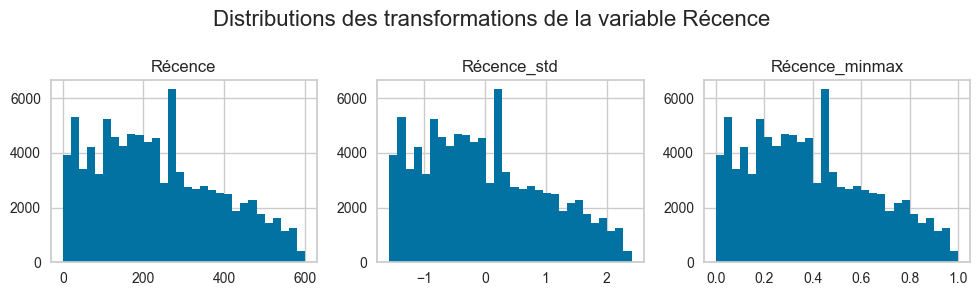

In [18]:
# Affichage des distributions
ax = df_features[features_recence].hist(bins=30, layout=(1, 3), figsize=(10, 3))
plt.suptitle('Distributions des transformations de la variable Récence', size=16)
plt.subplots_adjust(top=0.92)
plt.tight_layout()
plt.show()

* La version après mise à l'échelle via StandardScaler n'apporte rien en terme de forme de distribution
* La version retenue est **`Récence_minmax`**

## 2.2 Fréquence

* La Fréquence est le nombre de commandes d'un client sur la période considérée
* La feature **Fréquence** a été binarisée (0 ou 1) pour tenir compte de la répartition très déséquilibrée entre les clients n'ayant passsé qu'une commande et les autres  
* Par souci de cohérence elle a été renommée **`Fréquence_minmax`** même si il n'était pas nécessaire qu'elle fasse l'objet d'une mise à l'échelle via MinMaxScaler. C'est cette 'version' qui est retenue

In [19]:
# Liste des features
features_frequence = ['nb_commandes', 'Fréquence_minmax']

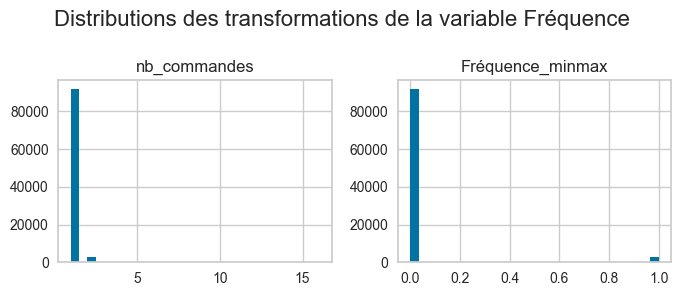

In [20]:
# Affichage des distributions
ax = df_features[features_frequence].hist(bins=30, layout=(1, 2), figsize=(7, 3))
plt.suptitle('Distributions des transformations de la variable Fréquence', size=16)
plt.subplots_adjust(top=0.92)
plt.tight_layout()
plt.show()

## 2.3 Montant

* La feature **Montant** correspond au montant total dépensé par un client sur la période considérée
* Cette feature dans sa forme d'origine présente une distribution fortement asymétrique, et de ce fait a été transformée en plusieurs versions pour être plus facilement exploitable par les modèles de clustering

In [21]:
# Liste des features
features_montant = [
    'Montant', 'Montant_minmax', 'Montant_std', 'Montant_std_minmax', 'Montant_log_minmax',
    'Montant_qtuni_minmax', 'Montant_qtnorm_minmax', 'Montant_boxcox_minmax', 'Montant_class_minmax'
]

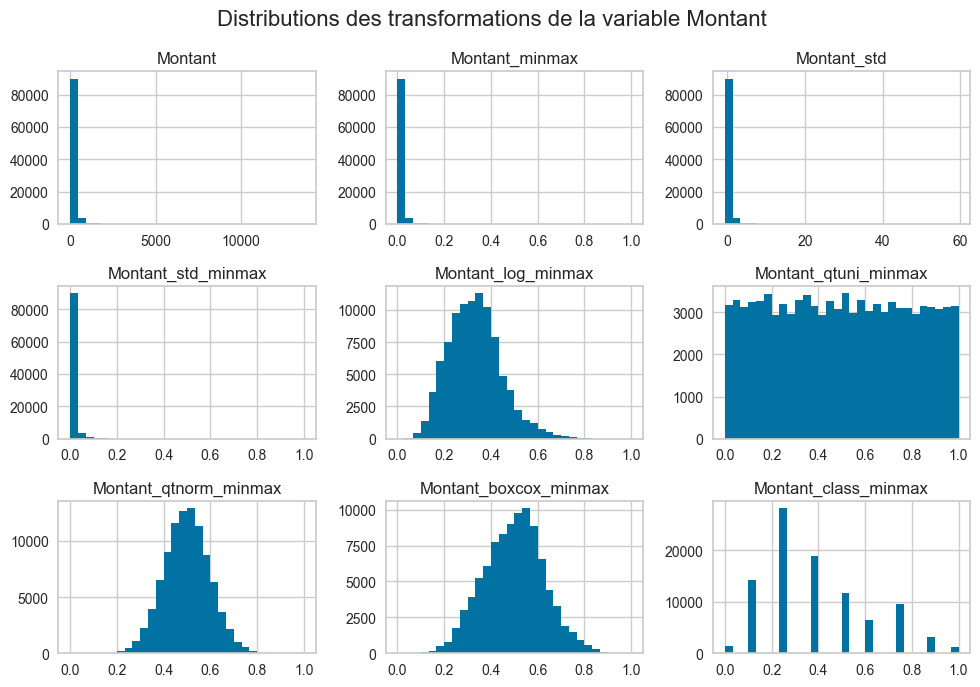

In [22]:
ax = df_features[features_montant].hist(bins=30, layout=(3, 3), figsize=(10, 7))
plt.suptitle('Distributions des transformations de la variable Montant', size=16)
plt.subplots_adjust(top=0.92)
plt.tight_layout()
plt.show()

* Versions à tester :  
   * **`Montant_log_minmax`**
   * **`Montant_qtuni_minmax`**
   * **`Montant_qtnorm_minmax`**
   * **`Montant_boxcox_minmax`**
   * **`Montant_class_minmax`**

## 2.4 Jeu de combinaisons de features à tester

In [23]:
# Liste des combinaisons de features à tester
test_features_set = [
    ['Récence_minmax', 'Fréquence_minmax', 'Montant_log_minmax'],
    ['Récence_minmax', 'Fréquence_minmax', 'Montant_qtuni_minmax'],
    ['Récence_minmax', 'Fréquence_minmax', 'Montant_qtnorm_minmax'],
    ['Récence_minmax', 'Fréquence_minmax', 'Montant_boxcox_minmax'],
    ['Récence_minmax', 'Fréquence_minmax', 'Montant_class_minmax']    
]

# 3 Modèle de clustering KMeans

## 3.1 Présentation de l'algorithme

**KMeans** est un algorithme de clustering qui regroupe des ensembles de données en **k** groupes distincts basés sur des similarités. Il est particulièrement efficace pour identifier des clusters bien séparés si les données sont relativement bien distribuées.

**Fonctionnement**  
* L'algorithme commence par initialiser k points aléatoires appelés centroïdes, chacun représentant le centre initial d'un cluster  
* Ensuite, chaque point du jeu de données est assigné au cluster dont le centroïde est le plus proche (distance euclidienne)  
* Après cette étape, les positions des centroïdes sont recalculées en tant que moyenne de tous les points assignés à leur cluster respectif
* Ce processus est répété jusqu'à que les positions des centroïdes n'évoluent plus de manière significative

**Paramètres principaux**  
* **n_clusters (k)** : nombre de clusters à former (= nombre de centroïdes)  
* **init** : méthode d'initialisation des centroïdes. `k_means++` permet après le positionnement aléatoire du premier centroïde, d'améliorer la dispersion des centroïdes initiaux en maximisant leur distance les uns par rapport aux autres  

## 3.2 Paramétrage du modèle

* **`n_clusters`** : entre 3 et 10, à tester. Pour ne sélectionner que ceux entre 5 et 8  
* **`inti`** : `k_means++` pour avoir une dispersion optimisée des centroïdes
* **`random_state`** : fixe, pour avoir un maximum de stabilité entre les différents tests

## 3.3 Recherche du nombre optimal de clusters / version de la feature `Montant`

* **Méthodes de recherche du nombre optimal de clusters :**  
    * **Méthode du coude (Elbow Method)** : examine la variance expliquée en fonction du nombre de clusters et cherche le point où l'ajout d'un autre cluster ne donne pas une amélioration significative de la variance expliquée.
    * **Score Calinski-Harabasz** : calcule un rapport de la dispersion entre les clusters et la dispersion à l'intérieur des clusters pour différents nombres de clusters. Le nombre optimal est celui qui maximise ce score.
    * **Score de Silhouette** : mesure la qualité de l'assignation d'un point dans un cluster en comparant sa distance aux points du même cluster avec sa distance aux points des autres clusters. Le score est compris entre -1 et 1, une valeur élevée indiquant que les clusters sont bien séparés et ont une bonne densité.  

* **Démarche  :**
    * Recherche visuelle à partir des graphiques Elbow Method et Calinsky Harabasz, pour chaque version de la feature `Montant`
    * Vérification du score de Silhouette du modèle retenu
    * Vérification des distances inter-cluster
    * Affichage de la répartition des clients par cluster
    * Vérification de l'interprétabilité de la segmentation 

### 3.3.1 Recherche visuelle

La bibliothèque `YellowBricks` fournit des outils simples permettant la visualisation du nombre optimal de clusters, pour les méthodes du coude et de Calinsky-Harabasz.

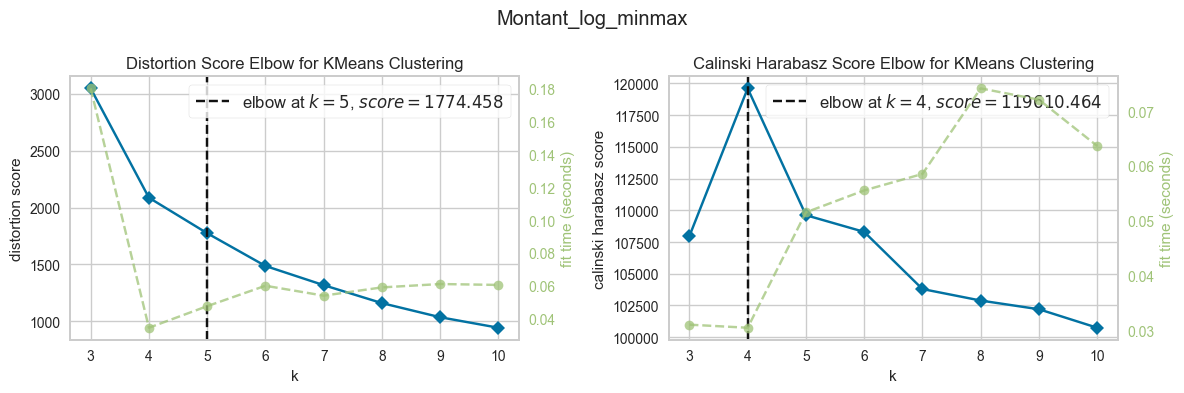

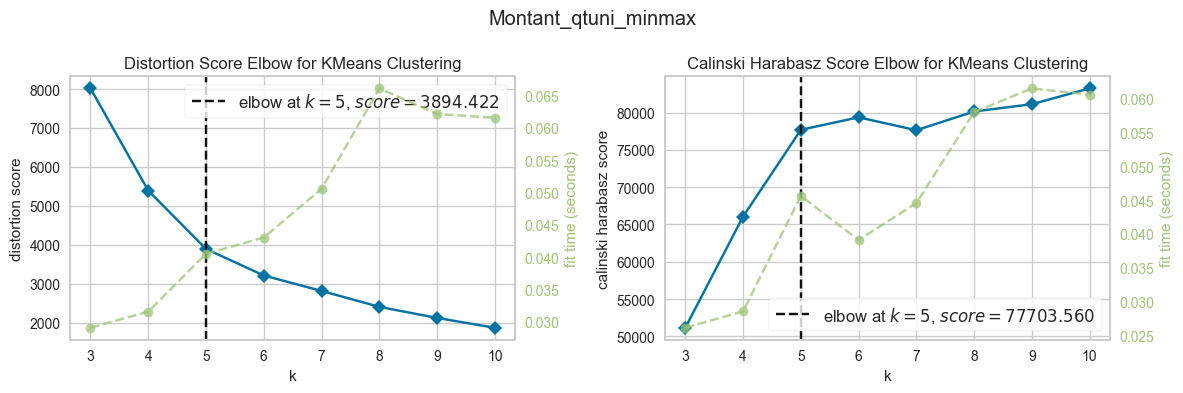

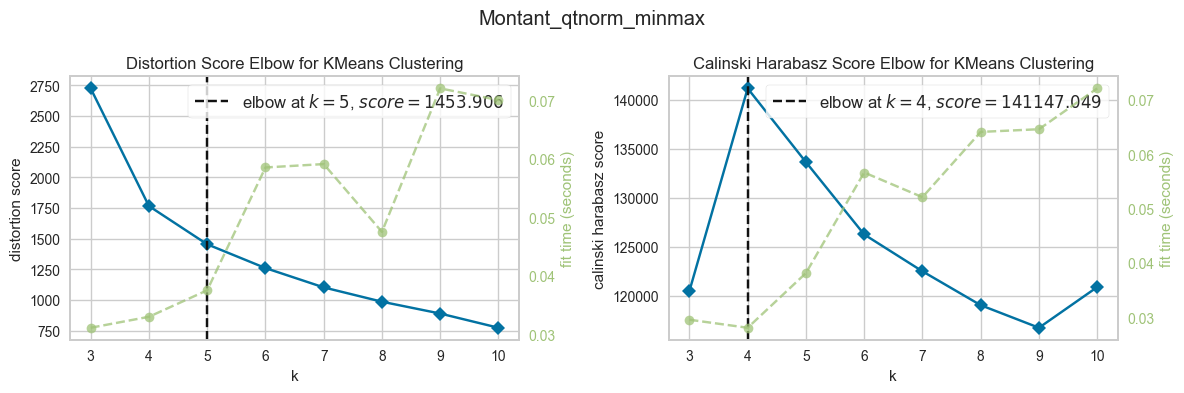

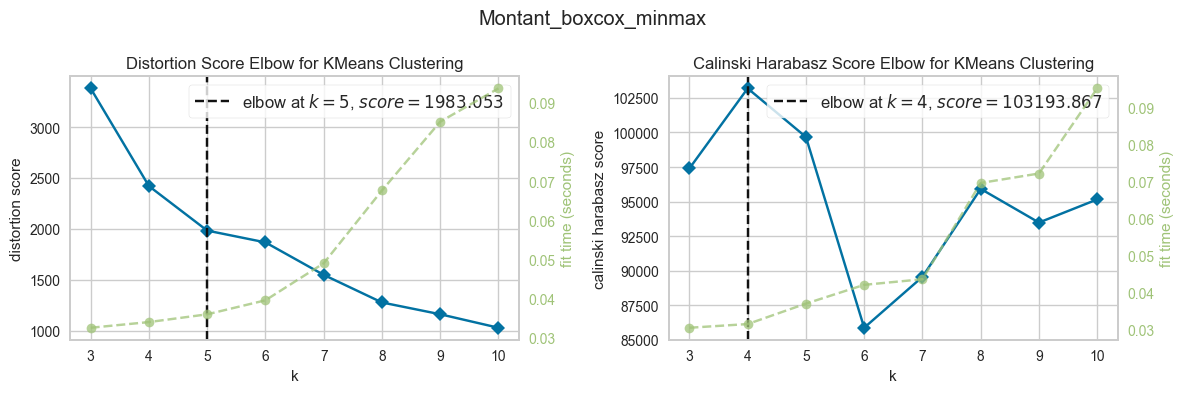

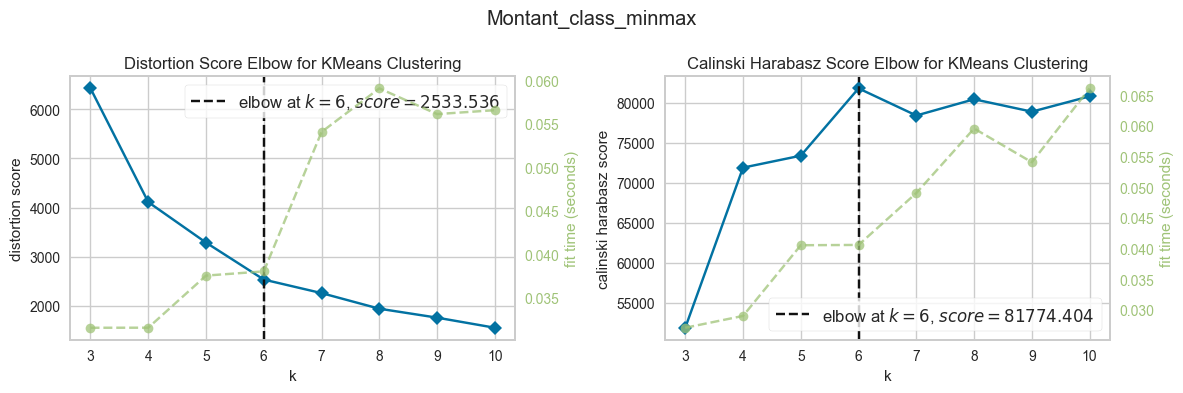

In [24]:
# Boucle sur les versions de la feature `Montant`
for features in test_features_set:
    plot_kmeans_elbow_visualizers(df_features[features])
    print()

* La segmentation en **6 clusters** mise en avant par les 2 méthodes en utilistant la version de la feature **`Montant_class_minmax`** parait la plus cohérente du point de vue métier  

In [25]:
# Sélection des features pour la combinaison retenue
X = df_features[['Récence_minmax', 'Fréquence_minmax', 'Montant_class_minmax']]

In [26]:
# Nombre de clusters retenu
n_clusters = 6

### 3.3.2 Score de Silhouette

* Affichage du Silhouette plot (Yellowbricks)

FAST_MODE ON : chargement et affichage 'silhouette_plot_kmeans_6_clusters_Montant_class_minmax.png'


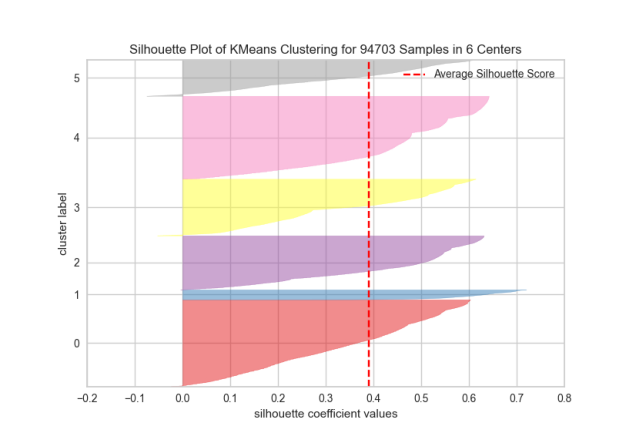

In [27]:
# Chargement et affichage du Silhouette plot si le fichier existe et si FAST_MODE est actif
# Sinon, génération du graphique, enregistrement sous forme de fichier png et affichage
filename = f'silhouette_plot_kmeans_{n_clusters}_clusters_{X.columns[-1]}.png'
if FAST_MODE and os.path.exists(filename):
    print(f"FAST_MODE ON : chargement et affichage '{filename}'")
    img = plt.imread(filename)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
else:
    # Génération, sauvegarde et affichage du graphique
    plot_silhouettevisualizer(X, n_clusters)

* Score de Silhouette moyen : inférieur à 0.4, les clusters sont globalement assez bien définis par rapport à leur cohésion et leur séparation
* Les clusters 2, 3 et 5 montrent des scores de silhouette négatifs, indiquant des points mal séparés
* Le cluster 1 est de taille plus petite (moins de clients) et de forme plus allongée, c'est le mieux défini (on peut supposer que ce cluster regroupe les clients ayant passé plus d'1 commande)
* Ces résultats sont à prendre avec précaution car cette méthode peut ne pas bien fonctionner avec des clusters de différentes densités

### 3.3.3 Distances inter-clusters

FAST_MODE ON : chargement et affichage 'intercluster_distance_map_kmeans_6_clusters_Montant_class_minmax.png'


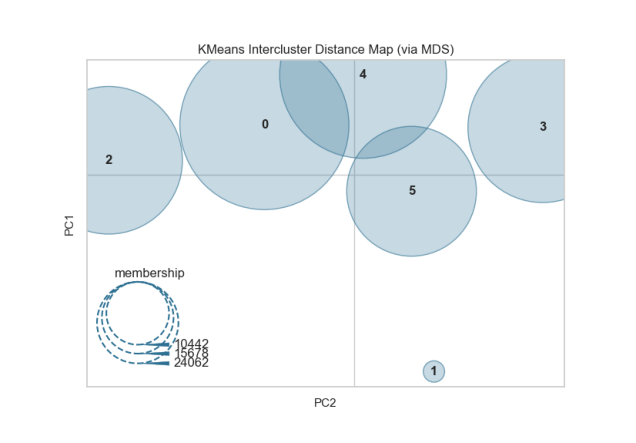

In [28]:
# Chargement et affichage du Silhouette plot si le fichier existe et si FAST_MODE est actif
# Sinon, génération du graphique, enregistrement sous forme de fichier png et affichage
filename = f'intercluster_distance_map_kmeans_{n_clusters}_clusters_{X.columns[-1]}.png'
if FAST_MODE and os.path.exists(filename):
    print(f"FAST_MODE ON : chargement et affichage '{filename}'")
    img = plt.imread(filename)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
else:
    # Génération, sauvegarde et affichage du graphique
    plot_intercluster_distance_map_kmeans(X, n_clusters)

In [29]:
# PCA 2 composantes principales : calcul du pourecentage de variance expliquée
print(f"Pourcentage de variance expliquée par les 2 premières composantes principales : {pca_explained_variance(X, 2) * 100:.2f} %")

Pourcentage de variance expliquée par les 2 premières composantes principales : 72.26 %


* Visualisation en 2 dimensions -> le chevauchement des clusters peut être moindre en réalité
* Repose sur une PCA dont les 2 composantes principales n'expliquent que 72 % de la variance

### 3.3.4 Répartition des clients par clusters

* Récupération des labels de clusters

In [30]:
# Instanciation et fit du modèle
kmeans_model = KMeans(n_clusters=6, random_state=0, init='k-means++')
kmeans_labels = kmeans_model.fit(X).labels_

In [31]:
# Ajout des labels au dataset
df_features['KMeans labels'] = kmeans_labels

# Sauvegarde
df_features.to_csv('df_features_kmeans.csv', index=False)

* Calcul du nombre de clients par cluster

In [32]:
# Nombre de clients par clusters
df_number_of_customers_by_clusters = df_features.groupby('KMeans labels')['Client'].count().reset_index()

In [33]:
display(df_number_of_customers_by_clusters)

,KMeans labels,Client
0,0,25217
1,1,2874
2,2,15678
3,3,16430
4,4,24062
5,5,10442


* Visualisation

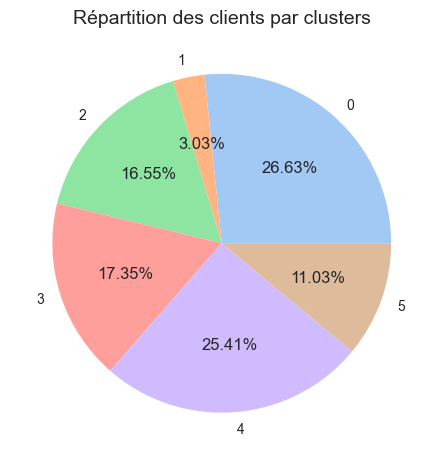

In [34]:
# Graphique de répartition
colors = sns.color_palette('pastel')[0:10]
plt.title('Répartition des clients par clusters', fontsize=14)
plt.pie(df_number_of_customers_by_clusters['Client'], labels=df_number_of_customers_by_clusters['KMeans labels'], colors = colors, autopct='%.2f%%')
plt.show()

* Le **cluster 1** ne représente que **3 % des clients** (les clients ayant passé plus d'une commande ?)  
* Le reste des clients est réparti de manière relativement homogène entre les 5 autres clusters

### 3.3.5 Vérification de l'interprétabilité

* L'affichage de boxplots des features RFM par cluster permet de visualiser leurs répartitions

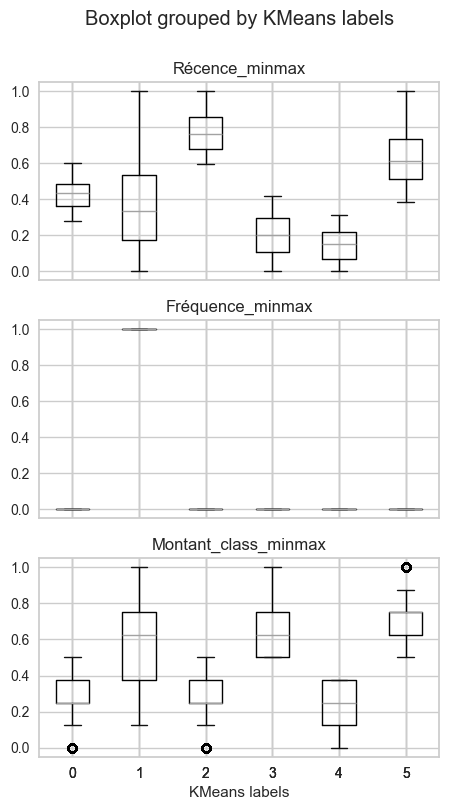

In [35]:
# Boxplots 
boxplots = df_features.boxplot(column=['Récence_minmax', 'Fréquence_minmax', 'Montant_class_minmax'], by='KMeans labels', grid=True, figsize=(5, 9), layout=(3, 1))

* Cette **segmentation en 6 clusters**, après classement par tranches de la variable `Montant`, semble facilement interprétable :  
   * Cluster 0 : clients ayant commandé il y relativement longtemps (Récence moyenne), n'ayant passé qu'une seule commande (Fréquence à 0), ayant peu dépensé (Montant dans la tanche basse)  
   * Cluster 1 : clients ayant passé plusieurs commandes  
   * Cluster 2 : clients ayant commandé il y a longtemps, ayant passé une seule commande, dépense plus faible  
   * Cluster 3 : clients ayant commandé plus récemment, une seule commande, dépense plus élevée  
   * Cluster 4 : clients ayant commandé plus récemment, une seule commande, dépense faible  
   * Cluster 5 : clients ayant commandé il y a longtemps, une seule commande, dépense plus élevée  

* L'interprétabilité peut être considérée comme techniquement validée
* Celle-ci devra cependant être confirmée avec une interpétation métier, reposant sur les valeurs non transformées des features RFM

## 3.4 Interprétation métier du clustering KMeans en 6 clusters

* Tableau récapitulatif des caractéristisques statistiques de chaque cluster

In [36]:
# Calcul des récences en mois
df_features['Récence_mois'] = round(df_features['Récence'] / 30)

# Liste des features à analyser
features_to_analyze = ['Récence_mois', 'Fréquence', 'Montant']

# Création du dictionnaire d'agrégation
aggregations = {feature: ['min', 'max', 'mean', 'median'] for feature in features_to_analyze}
aggregations['Client'] = 'count'

# Aggrégation des données
cluster_summary_kmeans_6 = df_features.groupby('KMeans labels').agg(aggregations)

# Calcul du pourcentage de clients
cluster_summary_kmeans_6['Percentage'] = (cluster_summary_kmeans_6['Client']['count'] / df_features['Client'].count()) * 100

# Affichage des statistiques
display(cluster_summary_kmeans_6)

Récence_mois                         Fréquence                  \
                       min   max       mean median       min max mean median   
KMeans labels                                                                  
0                      6.0  12.0   8.617480    9.0         0   0  0.0    0.0   
1                      0.0  20.0   7.361169    7.0         1   1  1.0    1.0   
2                     12.0  20.0  15.362419   15.0         0   0  0.0    0.0   
3                      0.0   8.0   4.014851    4.0         0   0  0.0    0.0   
4                      0.0   6.0   2.945516    3.0         0   0  0.0    0.0   
5                      8.0  20.0  12.646045   12.0         0   0  0.0    0.0   

              Montant                                Client Percentage  
                  min       max        mean   median  count             
KMeans labels                                                           
0               10.07    199.95   87.080396   79.640  25217  26.627456  
1               35.94   7571.63  308.360480  225.620   2874   3.034751  
2               11.63    199.98   85.041647   77.570  15678  16.554914  
3              150.00   7274.88  328.044922  226.180  16430  17.348975  
4                9.59    149.89   78.464869   73.610  24062  25.407854  
5              150.00  13664.08  382.157604  266.695  10442  11.026050

### 3.4.1 Cluster 0 : les clients Dormants

* Regroupe 27 % des clients  
* Ils n'ont passé qu'1 seule commande, il y a entre 6 mois et 1 an  
* Ils ont dépensé moins de 200 réals, moins de 80 réals pour 50 % d'entre eux

**Description** : Ces clients n'ont fait qu'un achat il y a longtemps et ont dépensé relativement peu. Leurs achats sont assez anciens, ce qui les rend moins susceptibles de revenir sans stimulation marketing ciblée.

### 3.4.2 Cluster 1 : les clients VIP

* Regroupe 3 % des clients  
* Ils ont passé plusieurs commandes, réparties sur toute la période  
* 50 %  d'entre eux ont dépensé au total plus de 225 réals

**Description** : Ces clients représentent une petite fraction de la clientèle d'Olist, mais sont très précieux. Ils ont fait plusieurs achats sur toute la période et dépensent généralement plus que les autres. Ce sont des clients fidèles avec un fort potentiel.

### 3.4.3 Cluster 2 : les clients Occasionnels

* Regroupe 17 % des clients  
* Ils n'ont passé qu'1 seule commande, il y a plus d'1 an  
* Ils ont dépensé moins de 200 réals, 85 réals en moyenne

**Description** : Ces clients n'ont effectué qu'un seul achat il y a plus d'un an et ont dépensé une somme modeste. Leur engagement est faible et ils risquent de ne pas revenir sans offres attractives ou relances.

### 3.4.4 Cluster 3 : les clients Récents à potentiel élevé

* Regroupe 17 % des clients  
* Ils n'ont passé qu'1 seule commande, il y a moins de 8 mois  
* Ils ont dépensé plus de 150 réals, dont 50 % d'entre eux plus de 225 réals

**Description** : Ce groupe comprend des clients qui ont récemment fait un achat d'un montant significatif. Bien que n'ayant acheté qu'une seule fois, leur dépense élevée et leur récence suggèrent un potentiel élevé.

### 3.4.5 Cluster 4 : les Nouveaux clients économes

* Regroupe 25 % des clients  
* Ils n'ont passé qu'1 seule commande, il y a moins de 6 mois  
* Ils ont dépensé moins de 150 réals, 78 réals en moyenne

**Description** : Ces clients ont effectué leur premier achat récemment mais ont dépensé peu. Ils pourraient être sensibles au prix ou en phase de test avec la plateforme.

### 3.4.6 Cluster 5 : les Anciens clients de valeur

* Regroupe 11 % des clients  
* Ils n'ont passé qu'1 seule commande, il y a plus de 8 mois  
* Ils ont dépensé plus de 150 réals, 380 réals en moyenne

**Description** : Bien que n'ayant commandé qu'une fois il y a longtemps, ces clients ont dépensé une somme significative. Ils représentent un potentiel non négligeable pour des ré-engagements réussis grâce à des stratégies de marketing personnalisé.

## 3.5 Conlusions KMeans

* Un clustering en 6 clusters via l'algorithme KMeans permet d'obtenir une analyse RFM interprétable au niveau métier
* Cette segmentation identifie clairement une spécificité de la clientèle Olist, à savoir les 3 % de clients n'ayant passé qu'une seule commande
* Les 5 autres segments regroupent chacun entre 11 et 27 % des clients, ce qui justifie des campagnes marketing personnalisées

* Afin d'améliorer la description des différents segments, il est possible d'y ajouter une note de satifaction moyenne :  

In [37]:
df_satisfaction = df_features.groupby('KMeans labels').agg(
    Satisfaction_KMeans = ('score_satisfaction', 'mean')
).reset_index()
display(df_satisfaction)

,KMeans labels,Satisfaction_KMeans
0,0,4.058909
1,1,4.169201
2,2,4.200121
3,3,4.008643
4,4,4.234124
5,5,4.059902


* Même si cette note moyenne reste très similaire d'un cluster à l'autre, il sera intéressant pour l'équipe Marketing d'Olist de surveiller l'évolution de cet indicateur dans le temps
* A noter que le meilleur score est celui du cluster 4, représentant les nouveaux clients

# 4 Modèle de clustering DBSCAN

## 4.1 Présentation de l'algorithme

**DBSCAN** est un algorithme de clustering basé sur la densité qui peut identifier un nombre arbitraire de clusters de formes variées.  
Il est particulièrement adapté pour gérer les anomalies en identifiant des "points de bruit" dans les données.  
Contrairement à KMeans, DBSCAN n'exige pas une spécification du nombre de clusters à l'avance.

**Fonctionnement**  
* L'algorithme commence par sélectionner un point non visité de l'ensemble du dataset   
* Il recherche ensuite tous les points voisins, ceux qui sont dans un rayon <= epsilon (hyperparamètre `eps`)
* Si le nombre de points voisins du point de départ est au moins égal à `min_samples` (deuxième hyperparamètre), le point de départ est considéré comme point central d'un cluster potentiel
* Si le nombre de points voisins est < `min_samples`, le point de départ est considéré comme un point de bruit
* Lorsqu'un point est identifié comme un point central, tous ses voisins sont ajoutés au cluster
* Ce processus se répète pour tous les points ajoutés au cluster, qui sont considérés tour à tour comme des points centraux, avec recherche de leurs voisins : le cluster se propage  
* Un point préalablement marqué comme un point de bruit peut devenir voisin d'un nouveau point central
* Lorsque tous les points ont été visités, un premier cluster est constitué, tous les points n'en faisant pas partie sont considérés comme des points de bruits
* Ce processus est répété pour tous les points n'ayant pas été visités et ne faisant pas déjà partie d'un cluster
* L'algorithme prend fin lorsque tous les points ont été visités et marqués comme faisant partie d'un cluster ou comme des points de bruit

**Paramètres principaux**  
* **eps (epsilon)** : distance maximale entre deux points pour qu'ils soient considérés comme voisins  
* **min_samples** : nombre minimal de points requis pour former un cluster dense    

## 4.2 Echantillonage des données

* DBSCAN peut monopiliser beaucoup de ressources, il est donc préférable de créer un **échantillon de données** pour les tests  
* Seulement 3% des clients ont commandé plus d'une fois, il ne faudrait pas que ces 3% ne soient pas représentés dans l'échantillon 
* La méthode `StratifiedShuffleSplit` de scikit-learn permet de s'assurer que la proportion des classes est maintenue dans l'échantillon 

In [38]:
# Initialisation avec taille de l'échantillon fixée à 10 % du dataset
stratified_shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)

# Récupération de l'échantillon
for _, sample_index in stratified_shuffle_split.split(df_features, df_features['Fréquence_minmax']):
    df_features_sample = df_features.loc[sample_index]

* Vérification de l'échantillonage

In [39]:
# Taille de l'échantillon
df_features_sample.shape

(9471, 26)

In [40]:
# Nombres de Fréquence à 0 et 1
df_features_sample['Fréquence_minmax'].value_counts().reset_index()

,Fréquence_minmax,count
0,0,9184
1,1,287


In [41]:
# Pourcentage de Fréquence à 1 (=pourcentage du nombre de clients ayant passé plus d'une commande)
round(df_features_sample.loc[df_features_sample['Fréquence_minmax'] == 1, ['Fréquence_minmax']].count() / df_features_sample.shape[0] * 100, 2)

Fréquence_minmax    3.03
dtype: float64

## 4.3 Recherche des hyperparamètres optimaux

### 4.3.1 `min_samples`

* Sans stratégie particulière pour cet hyperparamètre, quelques valeurs entre **3** et **20** seront testées dans un premier temps
* En fonction des résultats obtenus ce valeurs seront ajustées  

### 4.3.2 `eps`

* Espsilon représente la distance maximale entre deux points pour qu'il soient considérés comme voisins, c'est-à-dire appartenant au même cluster
* Cette distance doit être la plus grande possible pour ne pas avoir de points de bruits, c'est-à-dire des clients qui n'appartiendraient à aucun cluster
* Cette distance doit cependant rester suffisamment petite pour qu'un nombre minimum de clusters soient découverts  

* Scikit-learn met à disposition la classe `NearestNeighbors` qui  calcule la distance au plus proche voisin de chaque point dans un échantillon de données
* En triant et en traçant ces distances, il est possible d'observer où la courbe commence à augmenter fortement, ce qui peut permettre d'identifier une plage de recherche pour `eps`  

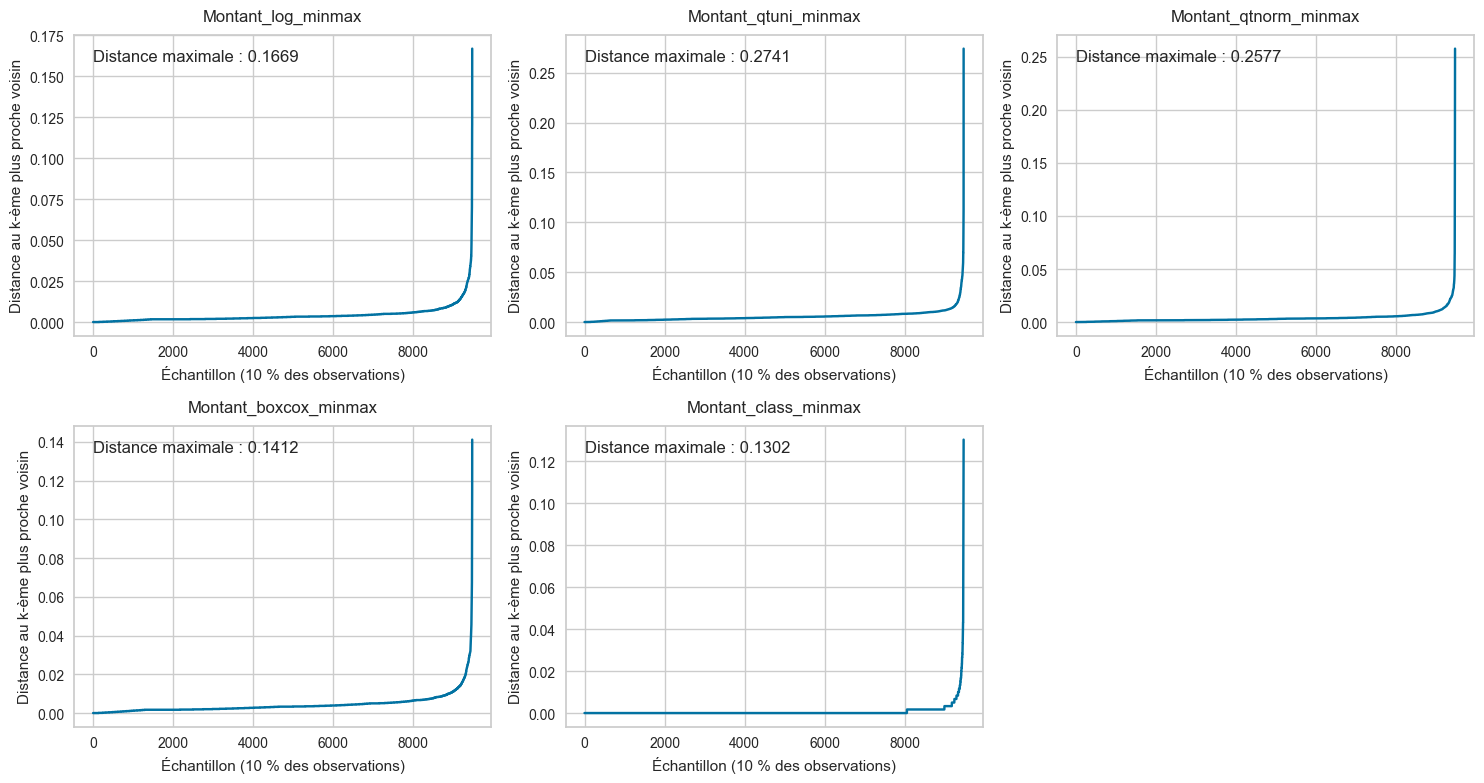

In [42]:
# Affichage des graphiques Nombres de points / Distance
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8)) 
axes = axes.flatten()
for i, features in enumerate(test_features_set):
    X = df_features_sample[features]
    epsilon_max = plot_elbow_nearest_neighbors(X, k=2, ax=axes[i])

# Hide any unused axes
for ax in axes[len(test_features_set):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

#### 4.3.2.1 Test d'une plage de valeurs d'`eps` pour chaque version de la feature `Montant`

* En partant du principe qu'il ne faut pas de points de bruit, ou vraiment très très peu, le choix d'epsilon doit se faire dans la plage haute des distances maximales pour chaque version  
* 10 valeurs seront testées sur une plage relativement réduite, allant jusqu'à la distance maximale calculée (cf graphiques)  

In [43]:
# Plages de paramètres 'eps' pour chaque version de 'Montant'
eps_values = [
    np.linspace(0.1375, 0.1669, 10),
    np.linspace(0.23, 0.2741, 10),
    np.linspace(0.23, 0.2577, 10),
    np.linspace(0.12, 0.1412, 10),
    np.linspace(0.11, 0.13, 10)
]

* La plage de valeurs de `min_samples` est comprise entre **3** et **20**

In [44]:
# Valeur 'min_samples'
min_samples_values = (3, 4, 5, 10, 15 ,20)

* Il n'existe pas de mécanisme comparable à `GridSearchCV` applicable à DBSCAN, mais cela peut être simulé en bouclant sur les plages de valeurs possibles pour **eps** et **min_samples**

In [45]:
# Getion du FAST_MODE
filename = 'df_dbscan_parameters_1.csv'
if FAST_MODE and os.path.exists(filename):
    print(f"FAST_MODE ON : Chargement du fichier '{filename}' et conversion en DataFrame")
    df_dbscan_parameters = pd.read_csv(filename)
else:
    dfs = []
    for features, eps_range in zip(test_features_set, eps_values):
        dfs.append(search_dbscan_parameters(df_features_sample, features, min_samples_values, eps_range))
    df_dbscan_parameters = pd.concat(dfs, ignore_index=True)
    df_dbscan_parameters.to_csv(filename)

FAST_MODE ON : Chargement du fichier 'df_dbscan_parameters_1.csv' et conversion en DataFrame


#### 4.3.2.2 Analyse des résultats

* Affichage des résultats avec au moins 4 clusters, trié par ordre croissant de nombres de clusters et de points de bruits

In [46]:
mask = df_dbscan_parameters['n_clusters'] >= 4
display(df_dbscan_parameters.loc[mask].sort_values(by=['n_clusters', 'n_noise'], ascending=[True, True]))

,Unnamed: 0,feature_montant,eps,min_samples_value,n_clusters,n_noise
245,245,Montant_class_minmax,0.110000,20,11,244
244,244,Montant_class_minmax,0.110000,15,12,142
251,251,Montant_class_minmax,0.112222,20,12,222
257,257,Montant_class_minmax,0.114444,20,12,222
263,263,Montant_class_minmax,0.116667,20,12,222
250,250,Montant_class_minmax,0.112222,15,13,127
281,281,Montant_class_minmax,0.123333,20,13,178
269,269,Montant_class_minmax,0.118889,20,13,202
275,275,Montant_class_minmax,0.121111,20,13,202
279,279,Montant_class_minmax,0.123333,10,14,56


* Seule la version de la feature `Montant` classée par tranches de montants aboutit à des clusterings de plus de 3 segments
* D'un point de vue métier, une segmentation en 11 clusters risque d'être ingérable
* `eps` : la valeur basse de la plage testée se retrouve plusieurs fois dans les résultats, la valeur haute n'est jamais atteinte
* `min_samples` : il semble que plus sa valeur est élevée, moins il y a de clusters... mais plus il y de points de bruits

* Ajustements :
    * Tests uniquement avec `Montant_class_minmax`
    * Décalage de la plage epsilon vers le bas, avec plus de valeurs
    * Pas de changements de la plage min_samples dans un premier temps

In [47]:
# Getion du FAST_MODE
filename = 'df_dbscan_parameters_2.csv'
if FAST_MODE and os.path.exists(filename):
    print(f"FAST_MODE ON : Chargement du fichier '{filename}' et conversion en DataFrame")
    df_dbscan_parameters = pd.read_csv(filename)
else:
    features = ['Fréquence_minmax', 'Récence_minmax', 'Montant_class_minmax']
    min_samples_values = (3, 4, 5, 10, 15 ,20)
    eps_values = np.linspace(0.105, 0.124, 20)
    df_dbscan_parameters = search_dbscan_parameters(df_features_sample, features, min_samples_values, eps_values)
    # Sauvegarde fichier csv
    df_dbscan_parameters.to_csv(filename)

FAST_MODE ON : Chargement du fichier 'df_dbscan_parameters_2.csv' et conversion en DataFrame


* Affichage des résultats avec au moins 4 clusters, trié par ordre croissant de nombres de clusters et de points de bruits

In [48]:
mask = df_dbscan_parameters['n_clusters'] >= 4
display(df_dbscan_parameters.loc[mask].sort_values(by=['n_clusters', 'n_noise'], ascending=[True, True]))

,Unnamed: 0,feature_montant,eps,min_samples_value,n_clusters,n_noise
35,35,Montant_class_minmax,0.110,20,11,244
41,41,Montant_class_minmax,0.111,20,11,244
17,17,Montant_class_minmax,0.107,20,11,245
23,23,Montant_class_minmax,0.108,20,11,245
29,29,Montant_class_minmax,0.109,20,11,245
...,...,...,...,...,...,...
78,78,Montant_class_minmax,0.118,3,19,7
12,12,Montant_class_minmax,0.107,3,19,8
18,18,Montant_class_minmax,0.108,3,19,8
0,0,Montant_class_minmax,0.105,3,20,8


* Ajustements
    * Resserremment de plage epsilon autour de 0.11
    * Décalage de la plage min_samples autour de 20

In [49]:
# Getion du FAST_MODE
filename = 'df_dbscan_parameters_3.csv'
if FAST_MODE and os.path.exists(filename):
    print(f"FAST_MODE ON : Chargement du fichier '{filename}' et conversion en DataFrame")
    df_dbscan_parameters = pd.read_csv(filename)
else:
    features = ['Fréquence_minmax', 'Récence_minmax', 'Montant_class_minmax']
    min_samples_values = (18, 19 ,20, 21, 22)
    eps_values = np.linspace(0.105, 0.115, 20)
    df_dbscan_parameters = search_dbscan_parameters(df_features_sample, features, min_samples_values, eps_values)
    # Sauvegarde fichier csv
    df_dbscan_parameters.to_csv(filename)

FAST_MODE ON : Chargement du fichier 'df_dbscan_parameters_3.csv' et conversion en DataFrame


* Affichage des résultats avec au moins 4 clusters, trié par ordre croissant de nombres de clusters et de points de bruits

In [50]:
mask = df_dbscan_parameters['n_clusters'] >= 4
display(df_dbscan_parameters.loc[mask].sort_values(by=['n_clusters', 'n_noise'], ascending=[True, True]))

,Unnamed: 0,feature_montant,eps,min_samples_value,n_clusters,n_noise
99,99,Montant_class_minmax,0.115000,22,11,243
1,1,Montant_class_minmax,0.105000,19,11,244
6,6,Montant_class_minmax,0.105526,19,11,244
11,11,Montant_class_minmax,0.106053,19,11,244
16,16,Montant_class_minmax,0.106579,19,11,244
...,...,...,...,...,...,...
60,60,Montant_class_minmax,0.111316,18,13,204
30,30,Montant_class_minmax,0.108158,18,13,205
35,35,Montant_class_minmax,0.108684,18,13,205
40,40,Montant_class_minmax,0.109211,18,13,205


* Ajustements
    * Élargissement de plage epsilon vers le haut
    * Élargissement de la plage min_samples vers le haut

In [51]:
# Getion du FAST_MODE
filename = 'df_dbscan_parameters_4.csv'
if FAST_MODE and os.path.exists(filename):
    print(f"FAST_MODE ON : Chargement du fichier '{filename}' et conversion en DataFrame")
    df_dbscan_parameters = pd.read_csv(filename)
else:
    features = ['Fréquence_minmax', 'Récence_minmax', 'Montant_class_minmax']
    min_samples_values = (19 ,20, 21, 22, 23, 24, 25)
    eps_values = np.linspace(0.105, 0.12, 40)
    df_dbscan_parameters = search_dbscan_parameters(df_features_sample, features, min_samples_values, eps_values)
    # Sauvegarde fichier csv
    df_dbscan_parameters.to_csv(filename)

FAST_MODE ON : Chargement du fichier 'df_dbscan_parameters_4.csv' et conversion en DataFrame


* Affichage des résultats avec au moins 4 clusters, trié par ordre croissant de nombres de clusters et de points de bruits

In [52]:
mask = df_dbscan_parameters['n_clusters'] >= 4
display(df_dbscan_parameters.loc[mask].sort_values(by=['n_clusters', 'n_noise'], ascending=[True, True]))

,Unnamed: 0,feature_montant,eps,min_samples_value,n_clusters,n_noise
216,216,Montant_class_minmax,0.116538,25,10,281
223,223,Montant_class_minmax,0.116923,25,10,281
230,230,Montant_class_minmax,0.117308,25,10,281
237,237,Montant_class_minmax,0.117692,25,10,281
244,244,Montant_class_minmax,0.118077,25,10,281
...,...,...,...,...,...,...
246,246,Montant_class_minmax,0.118462,20,13,202
253,253,Montant_class_minmax,0.118846,20,13,202
260,260,Montant_class_minmax,0.119231,20,13,202
267,267,Montant_class_minmax,0.119615,20,13,202


* Le nombre de clusters minimum est tombé à 10, mais le nombre de points de bruit a augmenté à 281 (soit 2.96 % du jeu de données)  
* Même si ce résultat est décevant, il serait intéressant de vérifier son interprétabilité  

## 4.4 Vérification de l'interprétabilité

Malgré ces mauvais résultats, il est intéressant de vérfier comment les features RFM sont distribuées dans les 5 clusters

### 4.4.1 Récupération des labels

In [53]:
# Sélection des features
X = df_features_sample[['Fréquence_minmax', 'Récence_minmax', 'Montant_class_minmax']]

In [54]:
# Initialisation et fit du modèle
dbscan_model = DBSCAN(eps=0.116538, min_samples=25)
dbscan_labels = dbscan_model.fit(X).labels_

In [55]:
# Récupération des étiquettes des clusters
df_features_sample['DBSCAN labels'] = dbscan_labels

### 4.4.2 Répartion des clients par clusters

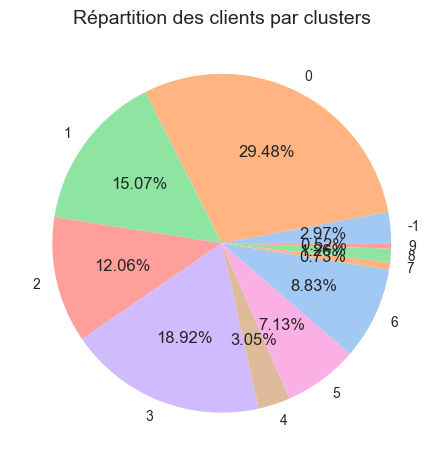

In [56]:
# Nombre de clients par clusters
df_number_of_customers_by_clusters = df_features_sample.groupby('DBSCAN labels')['Client'].count().reset_index()

# Graphique de répartition
colors = sns.color_palette('pastel')[0:7]
plt.title('Répartition des clients par clusters', fontsize=14)
plt.pie(df_number_of_customers_by_clusters['Client'], labels=df_number_of_customers_by_clusters['DBSCAN labels'], colors = colors, autopct='%.2f%%')
plt.show()

* La répartition n'est pas homogène, les clusters 7, 8 et 9 sont de très petites tailles  
* Le cluster -1 (points de bruit) regroupe à lui seul plus de clients que les 7, 8 et 9 réunis

### 4.4.3 Distribution des features RFM par clusters

* L'affichage de boxplots des features RFM par cluster permet de visualiser leurs répartitions

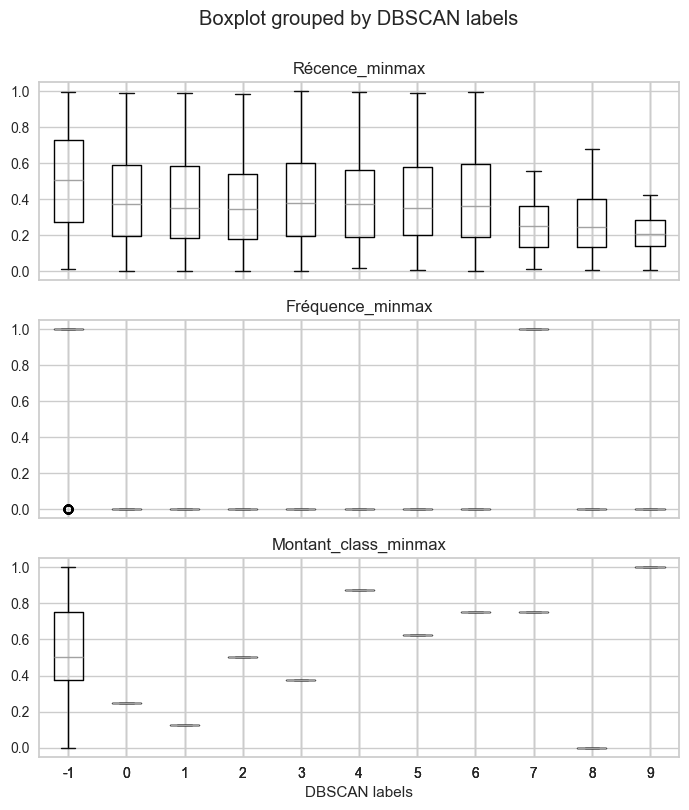

In [57]:
# Boxplots 
boxplots = df_features_sample.boxplot(column=['Récence_minmax', 'Fréquence_minmax', 'Montant_class_minmax'], by='DBSCAN labels', grid=True, figsize=(8, 9), layout=(3, 1))

* Le cluster labellisé -1 correspond aux points de bruit. Il regroupe des clients ayant passé 1 ou plusieurs commandes, sur toute la période, sur la plage la plus grande de montants
* Les clusters de 0 à 6 se distinguent uniquement par des montants dépensés différents
* Le cluster 7 est plus spécifique, il regroupe des clients ayant passé plusieurs commandes, relativement récemment (partie basse de la Récence), pour un montant total élevé
* Le cluster 8 représente des clients ayant passé 1 commande d'un montant faible, relativement récemment
* Enfin le cluster 9 regroupe des clients ayant passé 1 seule commande récente, dans la classe des montants les plus élevés

**Remarques**  
* Là où KMeans parvient à regrouper des classes de montants, DBSCAN n'y parvient pas : une piste serait de créer un nombre moins important de classe de montants
* DBSCAN semble avoir des difficultés à répartir les clients en fonction de la Récence : créer des classes (moins d'un mois, entre 2 mois et 3 mois...) serait une solution ?
* Le nombre trop élevé de points de bruit rend impossible cette segmentation d'un point de vue métier  

# 5 Modèle de clustering AgglomerativeClustering

## 5.1 Présentation de l'algorithme

**AglomerativeClustering** est un algorithme de clustering hiérarchique qui considère chaque observation comme un cluster, et qui fusionne les clusters deux à deux jusqu'à n'en obtenir plus qu'un.  
Ces fusions successives peuvent visualisées à l'aide d'un **dendrogramme**, qui permet de choisir le nombre de clusters désiré.

**Fonctionnement**  
* Au départ, chaque point est considéré comme un cluster individuel  
* L'algorithme fusionne les clusters deux à deux en fonction de leur proximité
* Cette étape est répétée jusqu'à ce que le nombre de clusters désiré soit atteint ou que tous les points ne forme qu'un seul cluster  

**Paramètres principaux**   
* **linkage** : type de liaison indiquant comment mesurer la proximité entre deux clusters :
    * liaison complète (`complete`) : la distance entre 2 clusters est la distance entre leurs 2 points les plus éloignés  
    * liaison simple (`single`) : la distance entre 2 clusters est la distance entre leurs 2 points les plus proches  
    * liaison moyenne (`average`) : la distance entre 2 clusters est la moyenne de toutes les distances entre les points d'un cluster et les points de l'autre  
    * liaison de Ward (`ward`) : à chaque fois que 2 clusters sont regroupés en 1, cherche à minimiser l'augmentation d'inertie intraclasse due au regroupement des 2 clusters.   
* **metric** : méthode de calcul de la distance : euclidienne, Manhattan...   
* A noter que le choix `linkage='ward'` impose `metric=euclidean`

## 5.2 Choix des hypermaramètres

* Plutôt que d'essayer d'obtenir des clusters éloignés les uns des autres, il est préférable d'obtenir des clusters dont les points de données sont les plus proches les uns des autres
* La méthode de liaison permettant cela est la méthode **ward**
* Lorsque `linkage='ward'`, la seule méthode de calcul de distance possible est la **distance euclidienne** (`metric='euclidean'`)

## 5.3 Échantillonage des données

* AgglomerativeClustering peut monopoliser beaucoup de ressources, il est donc préférable de créer un **échantillon de données** pour les tests  

* Création d'un échantillon de 25 % du dataset

In [58]:
# Initialisation avec taille de l'échantillon fixée à 10 % du dataset
stratified_shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)

# Récupération de l'échantillon
for _, sample_index in stratified_shuffle_split.split(df_features, df_features['Fréquence_minmax']):
    df_features_agglo = df_features.loc[sample_index]

## 5.4 Affichage des dendrogrammes

FAST_MODE ON : chargement et affichage 'dendrogrammes_ward.png'


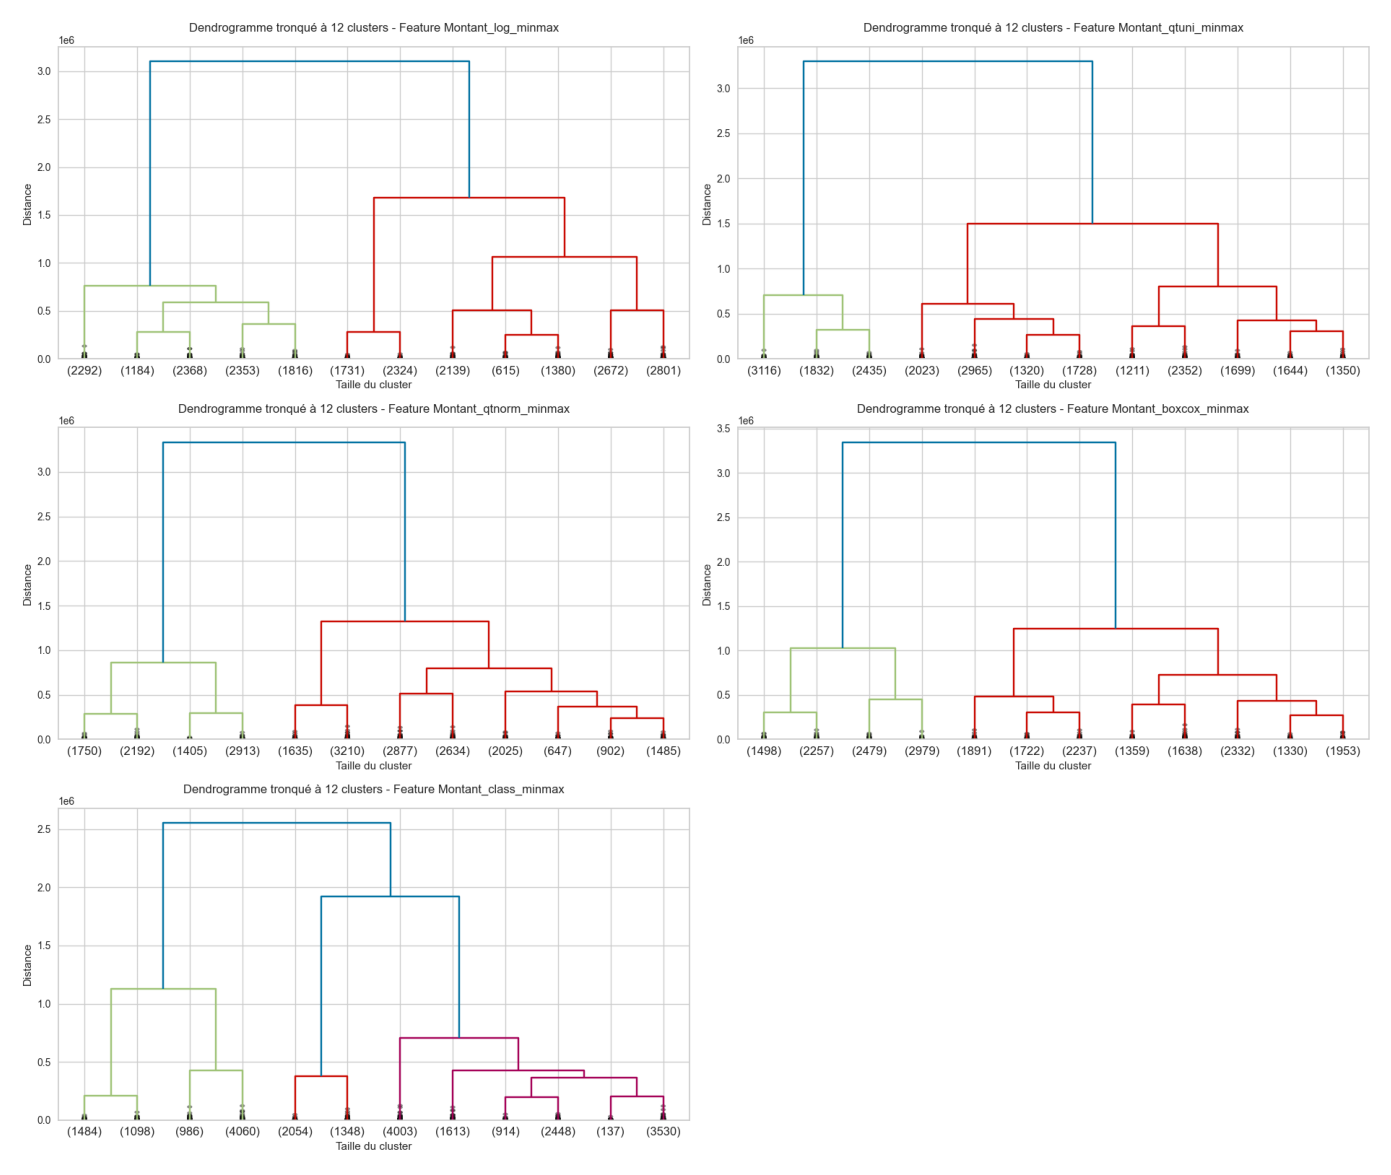

In [59]:
# Gestion du FAST_MODE
filename = f'dendrogrammes_ward.png'
if FAST_MODE and os.path.exists(filename):
    print(f"FAST_MODE ON : chargement et affichage '{filename}'")
    img = plt.imread(filename)
    fig, ax = plt.subplots(figsize=(18, 15))
    ax.imshow(img)
    plt.axis('off')
    plt.show()
else:
    # Génération des dendrogrammes 
    fig, axes = plt.subplots(3, 2, figsize=(19, 16))
    axes = axes.flatten()
    
    # Boucles sur les versions de la feature `Montant`
    for i, features in enumerate(test_features_set):
        # Sélection des features
        X = df_features_agglo[features]
        
        # Initialisation avec :
        #    * Linkage de type 'ward'
        #    * n_cluster=None : Pas de nombre de clusters prédéterminé
        #    * distance_threshold=0 : Seuil de distance de liaison au-delà duquel les clusters ne seront pas fusionnés à 0
        #                             pour laisser à l'algorithme la possibilité de fusionner 2 clusters même s'ils sont proches
        agglomerative_model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')
        
        # Fit du modèle
        agglomerative_model = agglomerative_model.fit(X)
    
        # Génération du dendrogramme
        plot_dendrogram(axes[i], agglomerative_model, 'ward', 'euclidean', 12)
    
    for ax in axes[len(test_features_set):]:
        ax.axis('off')
    
    plt.tight_layout()
    
    # Enregistrement
    plt.savefig(f'dendrogrammes_ward.png')
    
    plt.show()

* La distance entre 1 et 2 clusters est la plus grande pour toutes les versions de la feature `Montant`, à l'exception de celle classée par tranches de montants `Montant_class_minmax`
* Le dendrogramme de cette feature préconise une segmentaion en 3 clusters

## 5.5 Segmentation en 3 clusters

### 5.5.1 Clustering

In [60]:
# Initialisation AgglomerativeClustering avec 3 clusters, linkage ward
agglomerative_model = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')

* Fit sur le jeu de données complet et récupération des labels

In [61]:
# Sélection des features
X = df_features[['Récence_minmax', 'Fréquence_minmax', 'Montant_class_minmax']]

In [62]:
# Getion du FAST_MODE
filename = 'agglomerative_model.pkl'
if FAST_MODE and os.path.exists(filename):
    print(f"FAST_MODE ON : Chargement du fichier '{filename}'")
    with open(filename, 'rb') as file:
        agglomerative_model = pickle.load(file)
else:
    # Fit sur le jeu de données complet
    agglomerative_model.fit(X)
    # Sauvegarde modèle fitté au format pickle
    with open(filename, 'wb') as file:
        pickle.dump(agglomerative_model, file)

FAST_MODE ON : Chargement du fichier 'agglomerative_model.pkl'


In [63]:
# Ajout des labels de clusters à df_features
df_features['Agglomerative labels'] = agglomerative_model.labels_

### 5.5.2 Répartition des clients par cluster

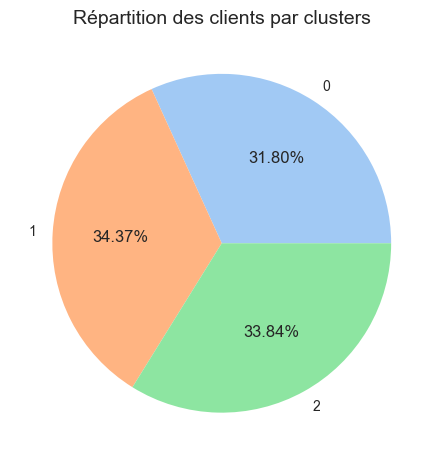

In [64]:
# Nombre de clients par clusters
df_number_of_customers_by_clusters = df_features.groupby('Agglomerative labels')['Client'].count().reset_index()

# Graphique de répartition
colors = sns.color_palette('pastel')[0:10]
plt.title('Répartition des clients par clusters', fontsize=14)
plt.pie(df_number_of_customers_by_clusters['Client'], labels=df_number_of_customers_by_clusters['Agglomerative labels'], colors = colors, autopct='%.2f%%')
plt.show()

### 5.3.3 Distribution des features RFM par cluster

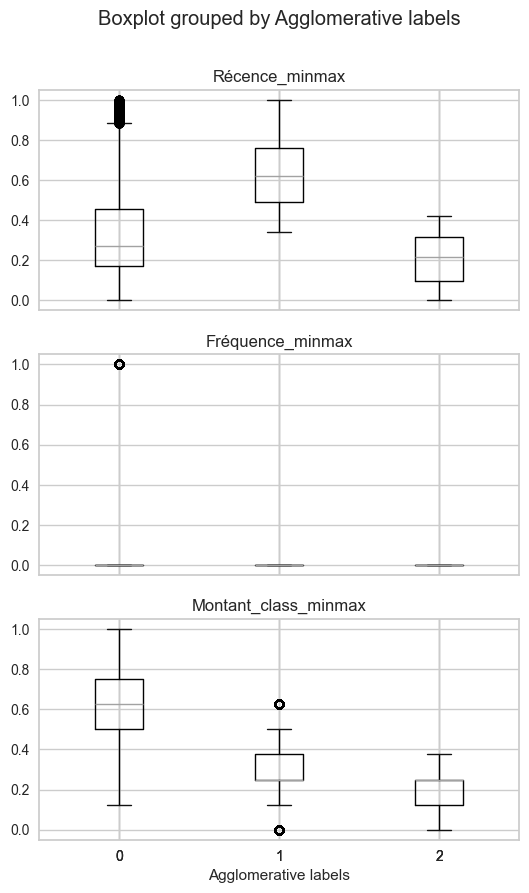

In [65]:
# Répartitions des features par clusters
boxplots = df_features.boxplot(column=['Récence_minmax', 'Fréquence_minmax', 'Montant_class_minmax'], by='Agglomerative labels', grid=True, figsize=(6, 10), layout=(3, 1))

* Interprétation :
   * Le cluster 0 rassemble des clients sur quasiment l'intégralité des valeurs des 3 features RFM. C'est le seul cluster contenant les clients ayant passé plus d'une commande
   * Clusters 1 et 2 :
      * Clients n'ayant passé qu'une commande, avec un montant dans la fourchette basse
      * Le cluster 1 correspond aux commandes passées il y a relativement longtemps, le cluster 2 aux commendes passées plus récemment
      * Il y a cependant chevauchement au niveau de la Récence, ce qui signifie que 2 clients ayant passés une seule commande à la même date, d'un même montant, pourraient se trouver dans 2 clusters différents
* Cette segmentation n'est pas efficace car il y a des cas de chevauchements : certains clients ayant des caractéristiques similaires pourraient se trouver dans des clusters différents

## 5.6 Conclusion du test AgglomerativeClustering

* La recherche d'une segmentation entre 3 et 10 clusters via le modèle **AgglomerativeClustering** n'a pas donné de résultat satisfaisant
* L'interprétation métier n'est pas possible  
* L'algorithme AgglomerativeClustering a une forte complexité algorithmique en temps et en espace mémoire, de fait il n'est pas le plus adapté vu la taille du dataset Olist.

# 6 Annexe : Visualisation du clustering KMeans après PCA

* Transformation des features via StandardScaler avant PCA

In [66]:
# Sélection des features utilisées
features = df_features[['Montant_class_minmax', 'Récence_minmax', 'Fréquence_minmax']]

# Transformation StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

* PCA à deux composantes et pourcentages de variance expliquée

In [67]:
# PCA à deux composantes
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

In [68]:
# Pourcentage de variance expliquée par chaque composante
explained_variance = pca.explained_variance_ratio_
ev_PC1 = explained_variance[0]*100
ev_PC2 = explained_variance[1]*100
ev_total = ev_PC1 + ev_PC2

* Création d'un dataframe avec PCA et labels de clusters

In [69]:
# Création DataFrame
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Ajout des labels de clusters
pca_df['KMeans labels'] = df_features['KMeans labels']

* Génération du biplot

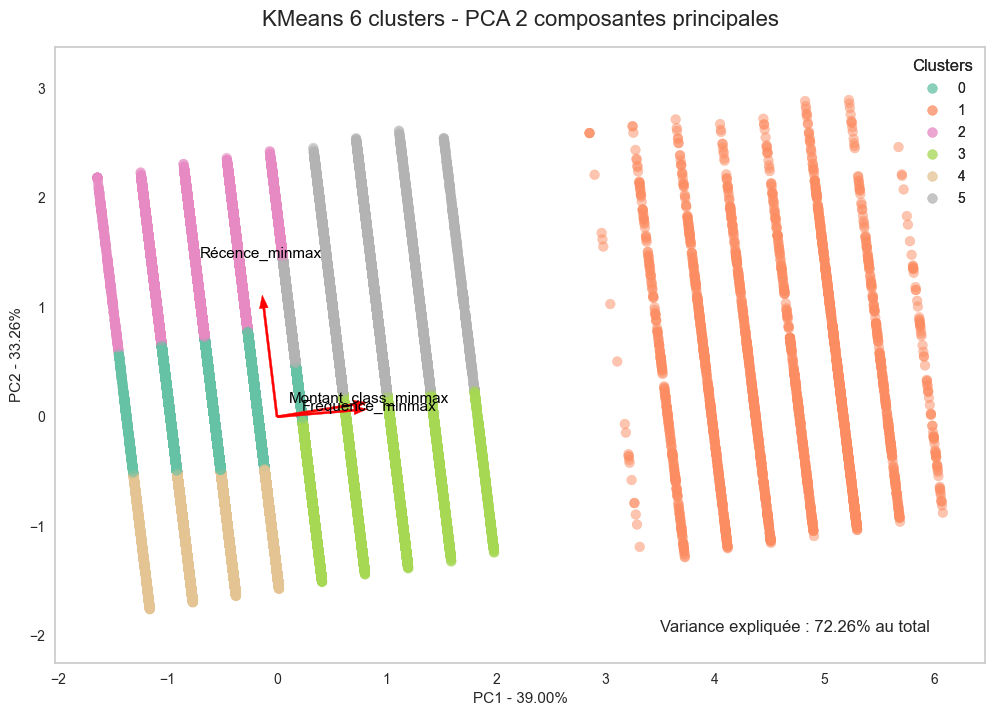

In [70]:
# Création du biplot
plt.figure(figsize=(12, 8))

# Scatter plot des composantes principales
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['KMeans labels'], cmap='Set2', alpha=0.5)

# Placement des vecteurs des variables d'origines
for i, (comp1, comp2) in enumerate(zip(pca.components_[0], pca.components_[1])):
    plt.arrow(0, 0, comp1, comp2, color='red', width=0.02, head_width=0.08)
    plt.text(comp1 * 1.2, comp2 * 1.5, features.columns[i], color='black', ha='center', va='center', fontsize=11)

# Étiquettes et titres
plt.xlabel(f'PC1 - {ev_PC1:.2f}%')
plt.ylabel(f'PC2 - {ev_PC2:.2f}%')
plt.title('KMeans 6 clusters - PCA 2 composantes principales', pad=15, fontsize=16)
plt.axis('equal')  # Pour garder les proportions correctes des flèches

# Ajout % de variance expliquée
plt.annotate(f'Variance expliquée : {ev_total:.2f}% au total',
             xy=(0.65, 0.05), xycoords='axes fraction')

# Ajout de la légende pour les clusters
legend = plt.legend(*scatter.legend_elements(), title="Clusters", loc='upper right')
plt.gca().add_artist(legend)

# Pas d'affichage de la grille
plt.grid(False)

plt.show()